# Analysis of hand drawn maps

This script is for analysing hand drawn maps of the Willunga sub-basin based on manual water table mapping exercise and survey and to make the figures for the paper.

Rasters are made in ArcGis using the hand drawn contour data and converting it to a raster using "Topo2Raster" tool

Script is run in the `conda activate geo_env` enviroment

## Import packages

In [1]:
from __future__ import division

#import affine
#import contextily
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import fiona
import geopandas as gpd
import matplotlib as mpl
from   matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from   matplotlib.patches import Patch
from   matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from   rasterio.crs import CRS
from   rasterio.enums import Resampling
from   rasterio.features import rasterize
import rasterio.mask
from   rasterio.plot import show
from   rasterio.transform import from_bounds
from   rasterio import shutil as rio_shutil
from   rasterio.vrt import WarpedVRT
from   rasterio import Affine

from   requests import Request
from   scipy.interpolate import interpn
from   scipy.interpolate import griddata
from   scipy import stats
import sys
import shapely
from   shapely.geometry import Point
from   shapely.geometry import mapping, Polygon
import string
from   owslib.wcs import WebCoverageService



%matplotlib inline

In [2]:
wt_cmap = 'rainbow'

In [3]:
filelocation = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\results_arrays'
figure_directory = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper'

In [4]:
names_list = []
arrays_list = []

for file in os.listdir(filelocation):
    if file.endswith(".out"):
        names_list.append(file)
        ar = np.loadtxt(os.path.join(filelocation, file))
        arrays_list.append(ar)
    else:
        pass
    
print(names_list)

['001.out', '002.out', '003.out', '004.out', '005.out', '008.out', '009.out', '012.out', '012b.out', '014.out', '016.out', '017.out', '021.out', '024.out', '025.out', '026.out', '029.out', '030.out', '031.out', '032.out', '033.out', '034.out', '036.out', '037.out', '049.out', 'AGC_001.out', 'AGC_011.out', 'AGC_014.out', 'AGC_015.out', 'AGC_016.out', 'AGC_018.out', 'DEW_01.out', 'DEW_02.out', 'DEW_03.out', 'DEW_04.out', 'E_0123.out', 'R01.out', 'TV_001.out', 'UWA_001.out', 'U_1949.out']


In [5]:
survey_levels = [0,10,20,30,40,50,60,70,80,90,100,125,150,175,200,225]

### Plotting all maps

C:\Users\mar886\AppData\Local\Temp/ipykernel_15736/2357695498.py:5: UserWarning: No contour levels were found within the data range.
  cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k")


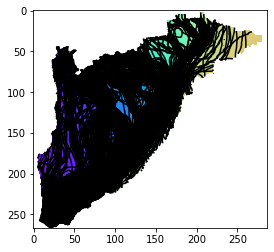

In [6]:
plt.figure()
for i in range(len(arrays_list)):
    #plt.figure()
    plt.imshow(arrays_list[i], cmap=wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k") 

### Calulate statistics

In [7]:
wt_array_stack = np.dstack(arrays_list)
print(wt_array_stack.shape)
wt_array_stack = np.moveaxis(wt_array_stack, source=2, destination=0)
print(wt_array_stack.shape)

(267, 287, 40)
(40, 267, 287)


In [8]:
max_array = np.amax(wt_array_stack, axis=0)
min_array = np.amin(wt_array_stack, axis=0)
range_array = max_array - min_array
std_array = np.nanstd(wt_array_stack, axis=0)
mean_array = np.nanmean(wt_array_stack, axis=0)

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mar886\AppData\Local\Temp/ipykernel_15736/1839270943.py:5: RuntimeWarning: Mean of empty slice
  mean_array = np.nanmean(wt_array_stack, axis=0)


### Plot statistics

In [9]:
mean_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

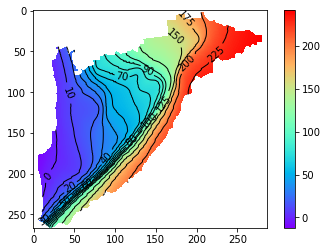

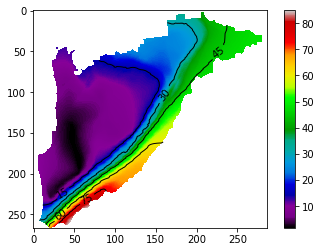

In [10]:
plt.figure()
m = plt.imshow(mean_array, cmap=wt_cmap)
cs = plt.contour(mean_array, levels=survey_levels, colors="k", linewidths=1)
plt.clabel(cs)
plt.colorbar(m)

plt.figure()
s = plt.imshow(std_array, cmap='nipy_spectral')
cs = plt.contour(std_array, colors="k", linewidths=1)
plt.clabel(cs)
plt.colorbar(s)

### Coefficient of variation

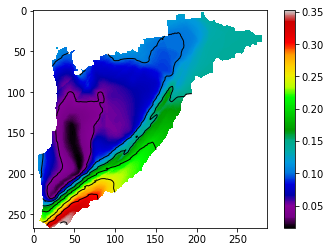

In [11]:
coeff_of_var = std_array/np.abs(mean_array+100)

# It needs to be scaled, if the values are too close to 0 they are just ridiculous...

plt.figure()
c = plt.imshow(coeff_of_var, cmap='nipy_spectral')
plt.contour(coeff_of_var, colors="k", linewidths=1)
plt.colorbar(c)

### Highlight variability on plain

- Doens't show much extra

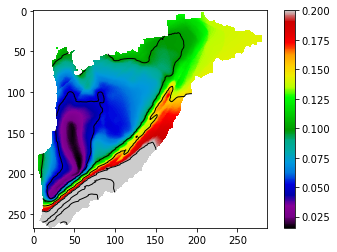

In [12]:
plt.figure()
c = plt.imshow(coeff_of_var, cmap='nipy_spectral', vmax=0.2)
plt.contour(coeff_of_var, colors="k", linewidths=1)
plt.colorbar(c)

### Highlight variability on the hills

- Doesn't really show much extra either

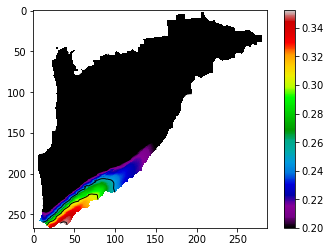

In [13]:
plt.figure()
c = plt.imshow(coeff_of_var, cmap='nipy_spectral', vmin=0.2)
plt.contour(coeff_of_var, colors="k", linewidths=1)
plt.colorbar(c)

### Plot variation in a few key parts

BUT I SHOULD DO THIS WITH THE ACTUAL SHAPE FILES NOT THE CONTOURS FROM THE RASTER - THEY ARE DIFFERENT

C:\Users\mar886\AppData\Local\Temp/ipykernel_15736/2619860221.py:6: UserWarning: No contour levels were found within the data range.
  cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k")
C:\Users\mar886\AppData\Local\Temp/ipykernel_15736/2619860221.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


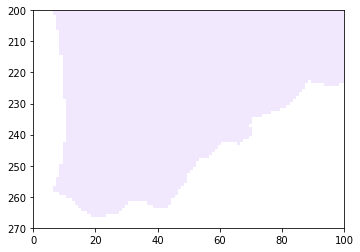

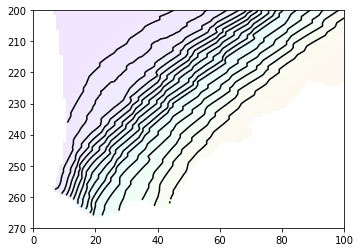

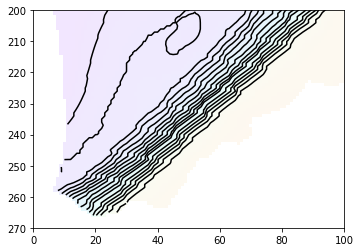

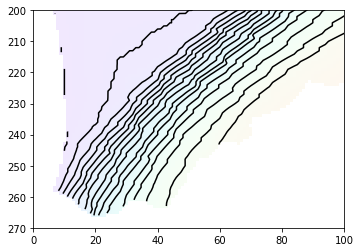

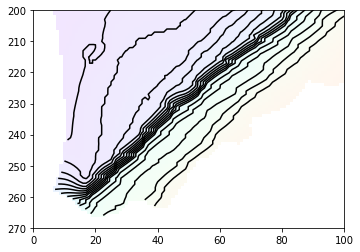

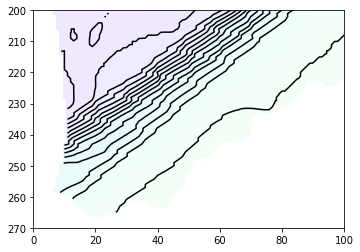

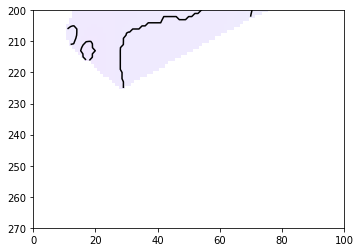

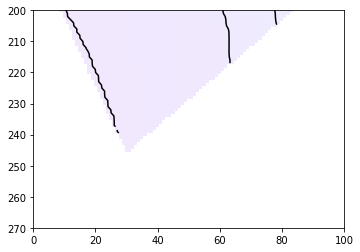

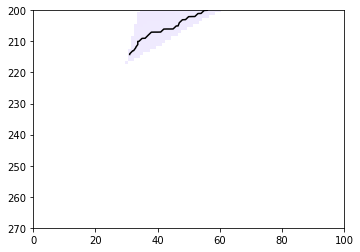

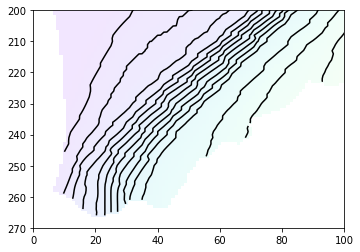

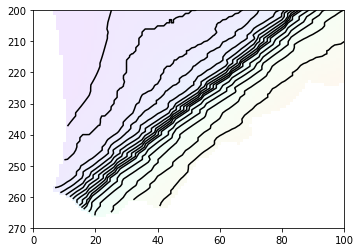

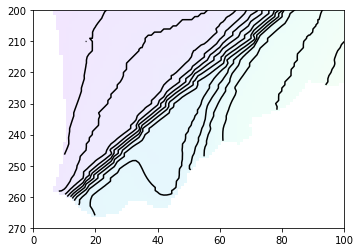

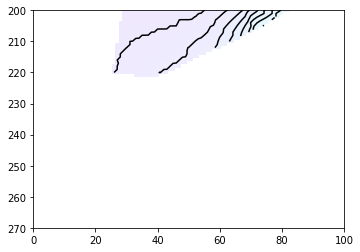

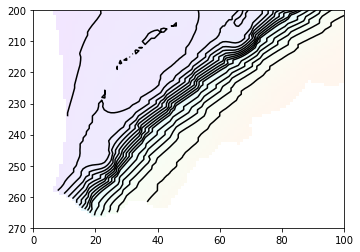

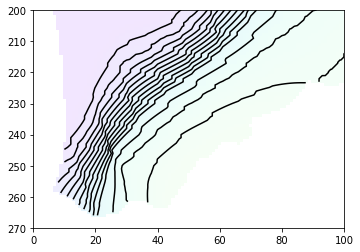

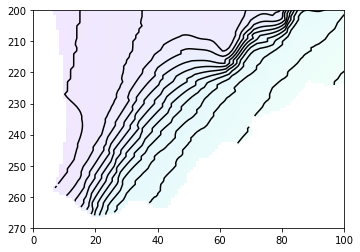

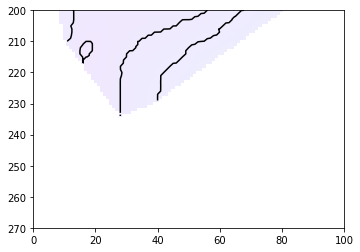

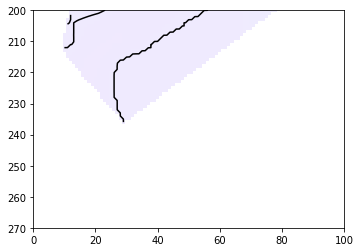

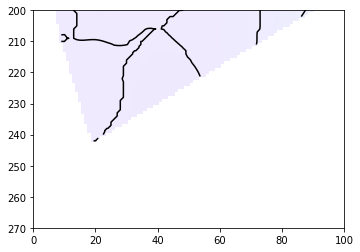

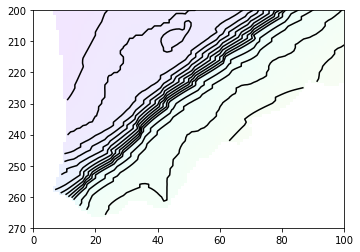

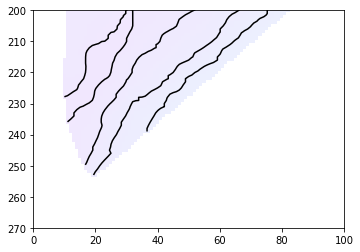

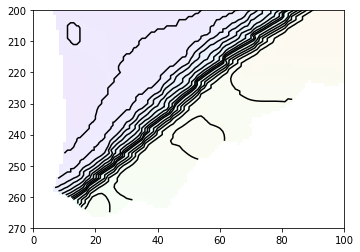

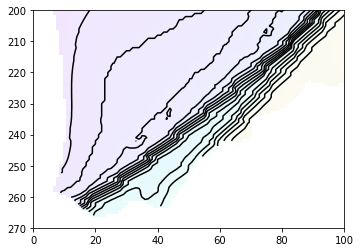

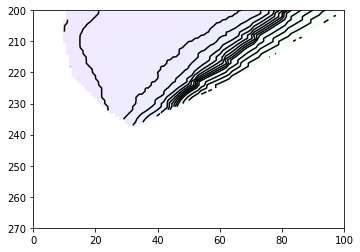

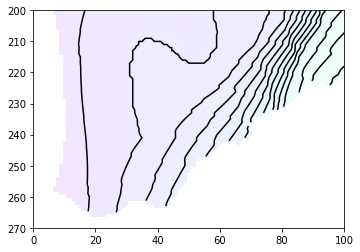

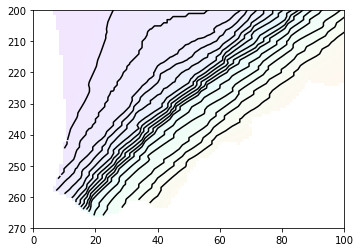

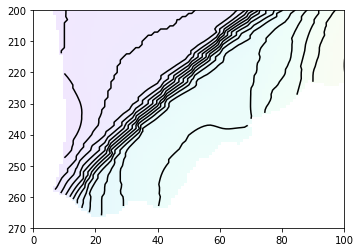

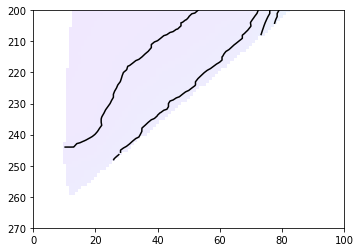

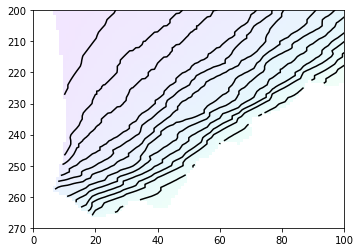

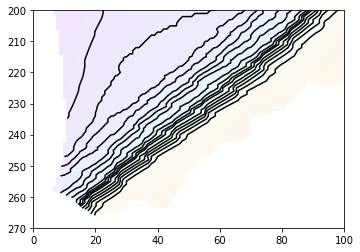

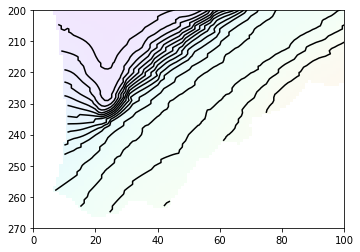

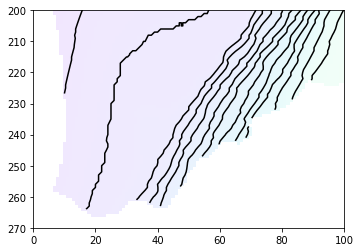

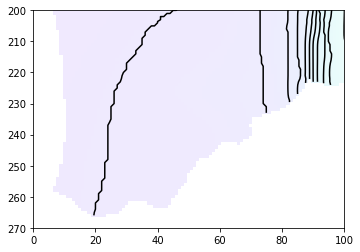

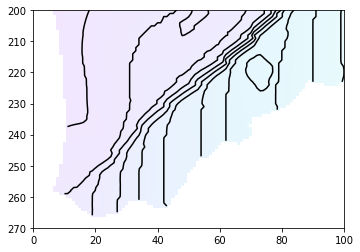

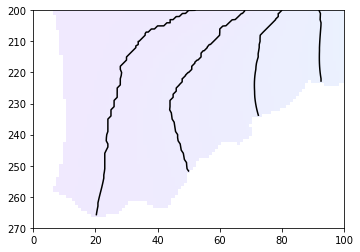

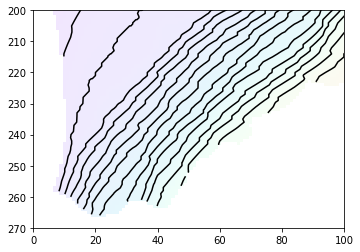

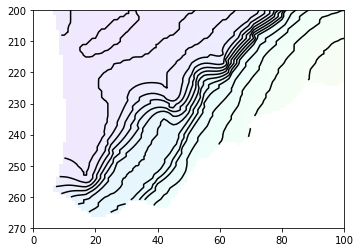

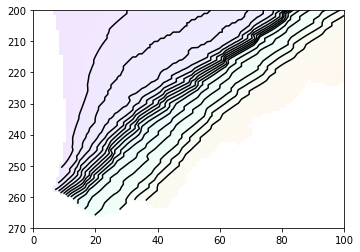

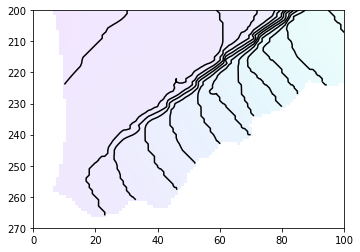

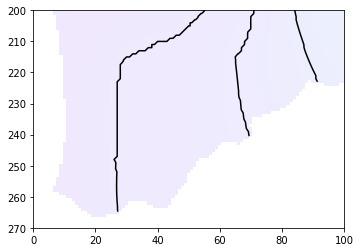

In [14]:
#plt.figure()
for i in range(len(arrays_list)):
    plt.figure()
    plt.imshow(arrays_list[i], cmap=wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    #plt.ylim(200,250)
    cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k") 
    
    plt.xlim(0,100)
    plt.ylim(200,270)
    axes = plt.gca()
    axes.invert_yaxis()

C:\Users\mar886\AppData\Local\Temp/ipykernel_15736/1026238948.py:6: UserWarning: No contour levels were found within the data range.
  cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k")
C:\Users\mar886\AppData\Local\Temp/ipykernel_15736/1026238948.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


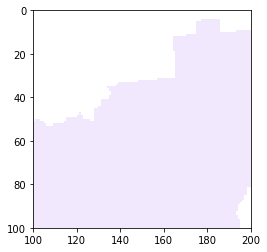

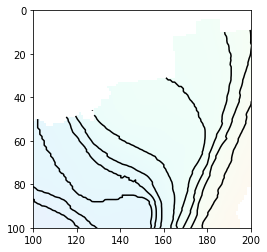

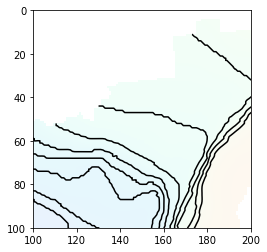

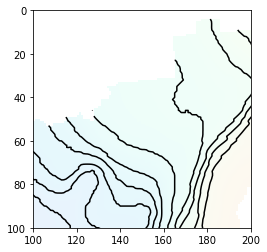

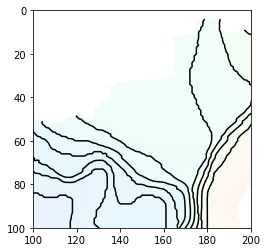

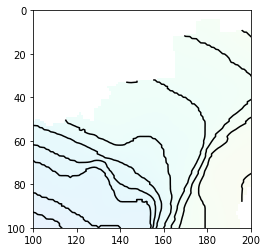

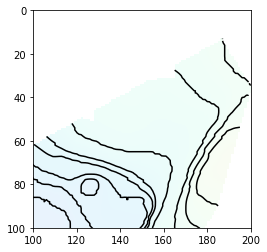

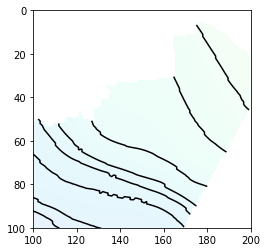

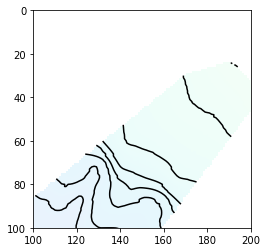

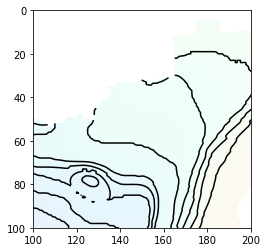

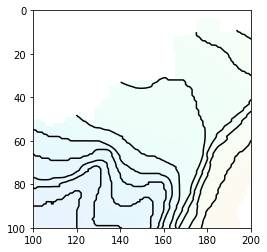

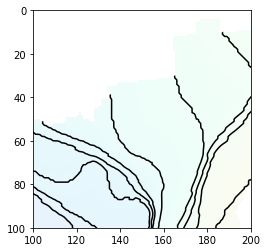

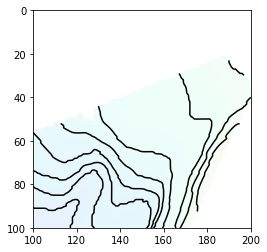

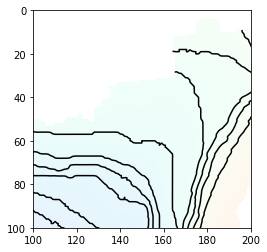

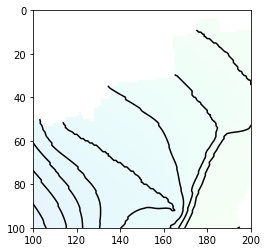

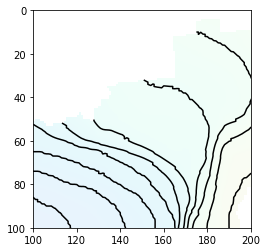

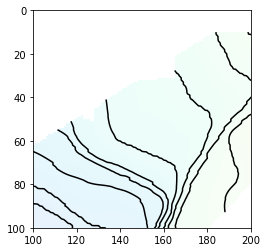

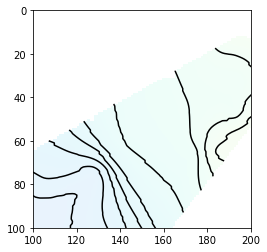

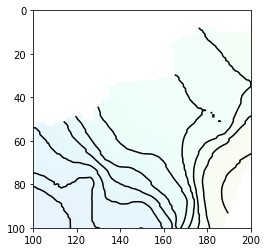

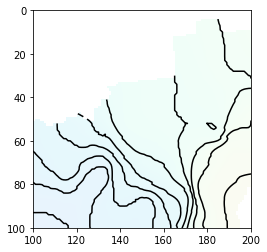

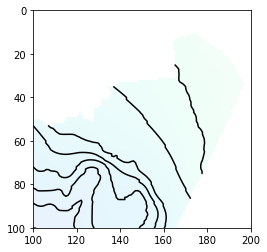

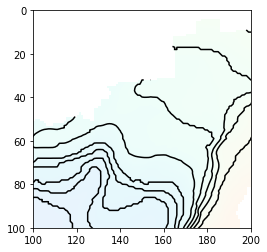

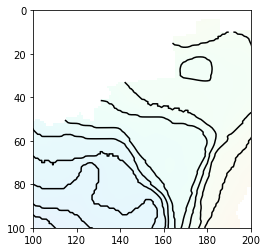

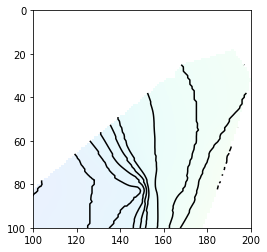

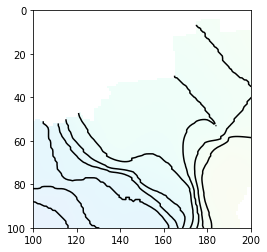

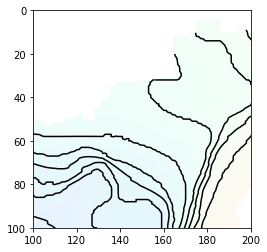

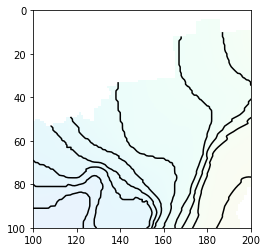

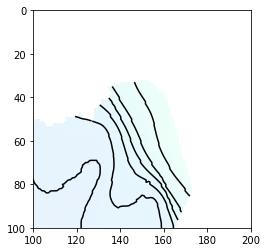

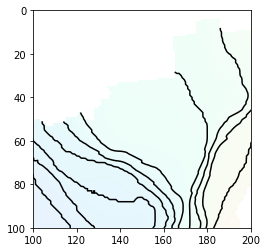

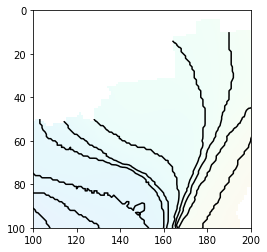

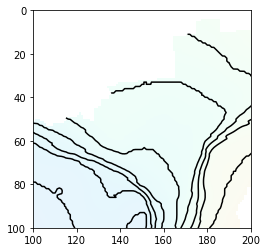

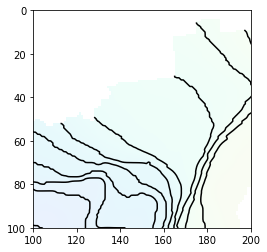

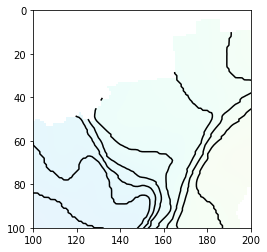

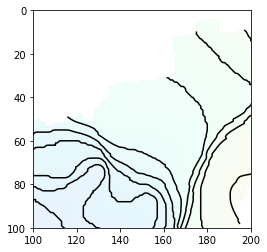

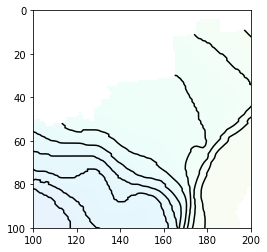

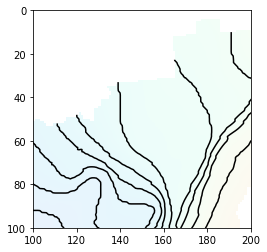

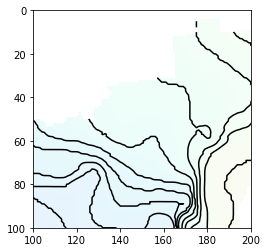

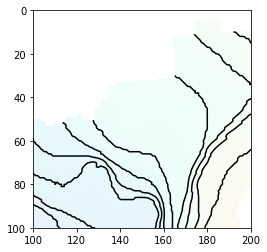

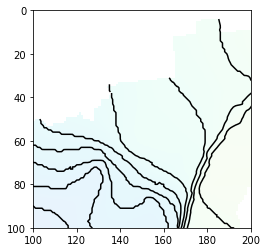

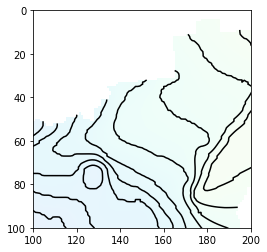

In [15]:
#plt.figure()
for i in range(len(arrays_list)):
    plt.figure()
    plt.imshow(arrays_list[i], cmap=wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    #plt.ylim(200,250)
    cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k") 
    
    plt.xlim(100,200)
    plt.ylim(0,100)
    axes = plt.gca()
    axes.invert_yaxis()

## Pull in well indices

In [16]:

f_well_ixs = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data',
                         "df_well_ixs.csv")

df_well_ixs = pd.read_csv(f_well_ixs)

df_well_ixs = df_well_ixs.drop(columns=['DHNO.1'])
df_well_ixs.head()

DHNO   rswl    well_ix  well_ix_x  well_ix_y letter
0  26558   4.09  (186, 20)        186         20    NaN
1  26565   4.33  (155, 40)        155         40    NaN
2  26585  18.22  (144, 56)        144         56    NaN
3  27050   5.54  (195, 50)        195         50    NaN
4  27063  15.90  (217, 35)        217         35    NaN

## Plots for paper

In [17]:
letters = ['a','b','c','d','e','f','g','h','i']

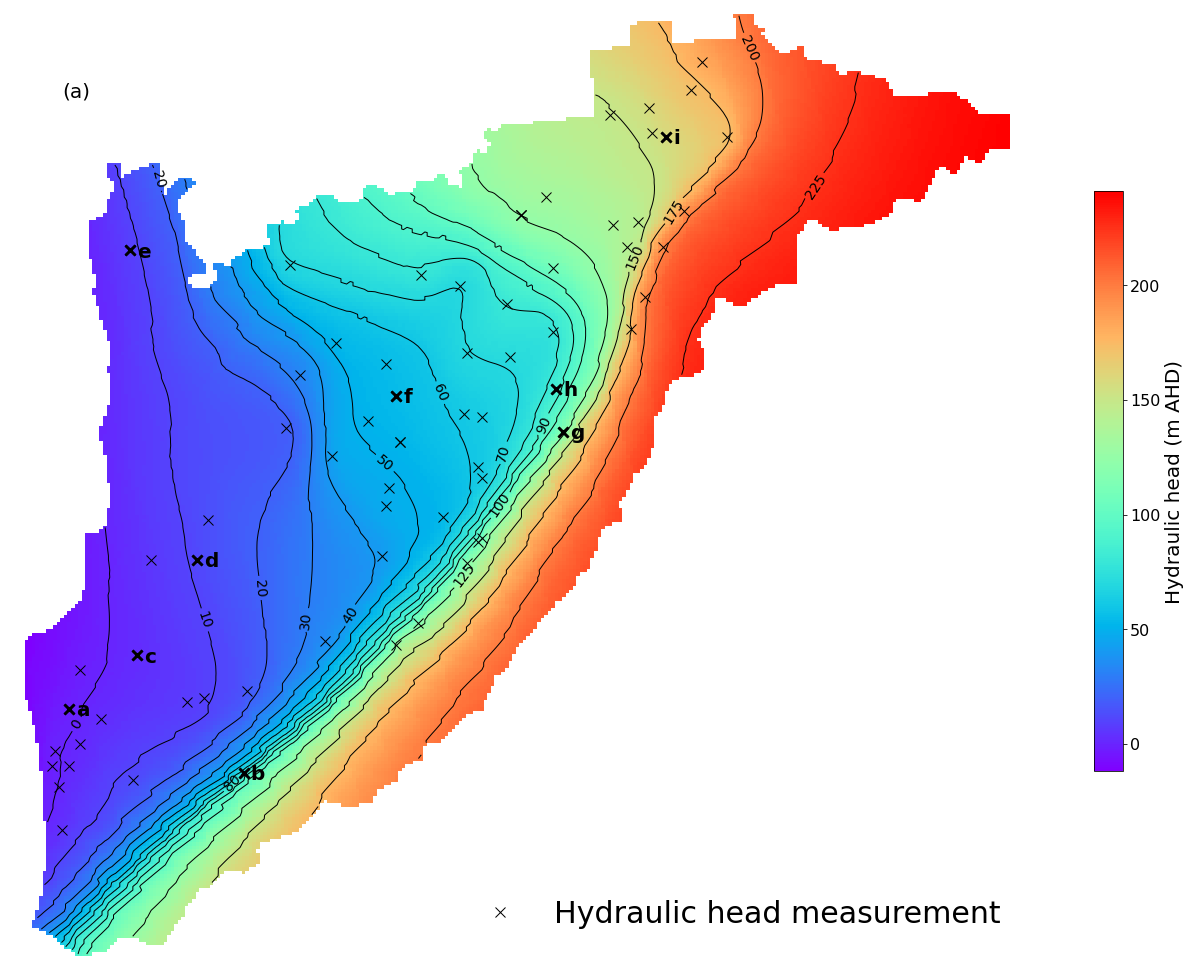

In [18]:
plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(mean_array, cmap=wt_cmap)
cs = plt.contour(mean_array, levels=survey_levels, colors="k", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Hydraulic head (m AHD)", fontsize=20)

for i in range(len(df_well_ixs)):
    y = df_well_ixs.iloc[i,3]
    x = df_well_ixs.iloc[i,4]
    letter = df_well_ixs.iloc[i,5]
    plt.plot(x,y,'x',c='k', markersize=10, label='_nolegend_')
    if letter in letters:
        plt.text(x+2,y+2,letter, fontsize=20, fontweight='bold',c="k")
        plt.plot(x,y,'x',c='k', markersize=10, markeredgewidth=3, label='_nolegend_')
    
axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
plt.legend(frameon=False, fontsize=30, loc=4)

plt.text(15,25, "(a)", fontsize=20)

nm = os.path.join(figure_directory, "mean")
plt.savefig(nm, dpi=300)

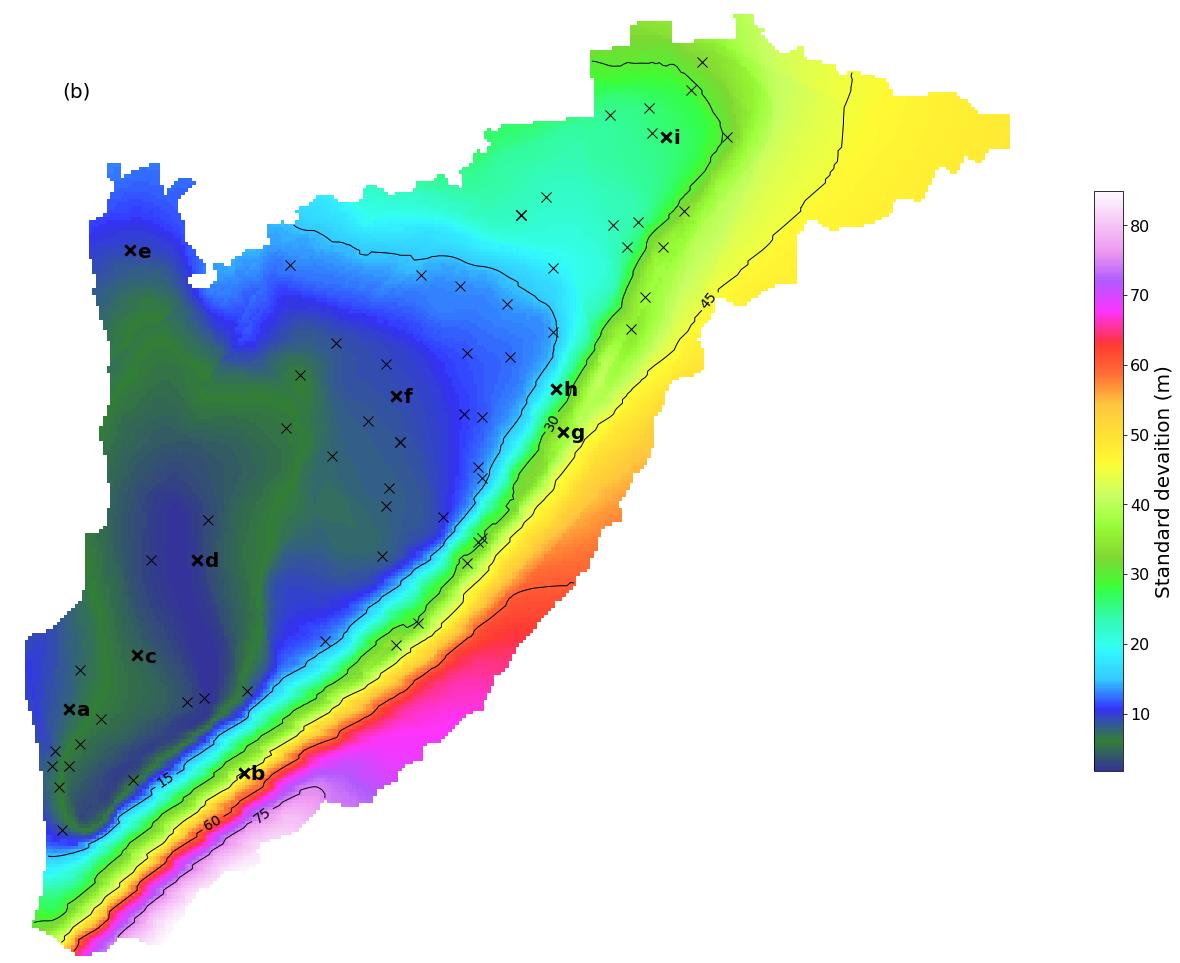

In [20]:
plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(std_array, cmap='gist_ncar', alpha=0.8)
cs = plt.contour(std_array, colors="k", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Standard devaition (m)", fontsize=20)

for i in range(len(df_well_ixs)):
    y = df_well_ixs.iloc[i,3]
    x = df_well_ixs.iloc[i,4]
    letter = df_well_ixs.iloc[i,5]
    plt.plot(x,y,'x',c='k', markersize=10, label='_nolegend_')
    if letter in letters:
        plt.text(x+2,y+2,letter, fontsize=20, fontweight='bold',c="k")
        plt.plot(x,y,'x',c='k', markersize=10, markeredgewidth=3,label='_nolegend_')
    
#axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

plt.text(15,25, "(b)", fontsize=20)

nm = os.path.join(figure_directory, "std")
plt.savefig(nm, dpi=300)

# Pull in shapefiles

In [23]:
wt_contour_shp_fldr = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data\wt_drawn_contours'

nm = 'ref_001_contours.shp'
contours_shp = gpd.read_file(os.path.join(wt_contour_shp_fldr,nm))

In [27]:
names_list[0][:-4]

'001'

In [ ]:
contour_shp_name_list = []
contour_shps_list = []

for i in range(len(names_list)):
    nm = "ref_%s_contours.shp"%names_list[i][:-4]
    contour_shp_name_list.append(nm)
    contours_shp = gpd.read_file(os.path.join(wt_contour_shp_fldr,nm))
    contour_shps_list.append(contours_shp)

print(len(names_list))

print(len(contour_shps_list))

In [ ]:
#Rename ref_030_contours.shp --> issue with contour column name
contour_shps_list[17]=contour_shps_list[17].rename(columns={"Contours_m":"Contour_m"})

#contour_shps_list[17]

In [91]:
#Rename ref_AGC_011_contours.shp --> issue with contour column name

contour_shps_list[26]=contour_shps_list[26].rename(columns={"contour_m":"Contour_m"})

#contour_shps_list[26]

fid  Contour_m                                           geometry
0    1.0         10  LINESTRING (138.44373 -35.34327, 138.44414 -35...
1    2.0         20  LINESTRING (138.48840 -35.16102, 138.48801 -35...
2    3.0          0  LINESTRING (138.44722 -35.30785, 138.44776 -35...
3    4.0         30  LINESTRING (138.49755 -35.17339, 138.49604 -35...
4    5.0         40  LINESTRING (138.50015 -35.18413, 138.50122 -35...
5    6.0         50  LINESTRING (138.50359 -35.17801, 138.50566 -35...
6    7.0         60  LINESTRING (138.51170 -35.17639, 138.51426 -35...
7    8.0         70  LINESTRING (138.51972 -35.17379, 138.51996 -35...
8    9.0         80  LINESTRING (138.53187 -35.16390, 138.53228 -35...
9   10.0         90  LINESTRING (138.55923 -35.16149, 138.55942 -35...
10  11.0        100  LINESTRING (138.56920 -35.15847, 138.56933 -35...
11  12.0        125  LINESTRING (138.59258 -35.14516, 138.59248 -35...
12  13.0        225  LINESTRING (138.68751 -35.13091, 138.68654 -35...
13  14.0        150  LINESTRING (138.62462 -35.12600, 138.62428 -35...
14  15.0        200  LINESTRING (138.66145 -35.12425, 138.66113 -35...
15  16.0        175  LINESTRING (138.64578 -35.12506, 138.64586 -35...

## Pull in shapefile of study area

In [114]:
study_extent_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\study_extent', 'study_extent.shp')
study_area_shp = gpd.read_file(study_extent_path)

## Plot individual contours, how simiar/different were they from one another

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

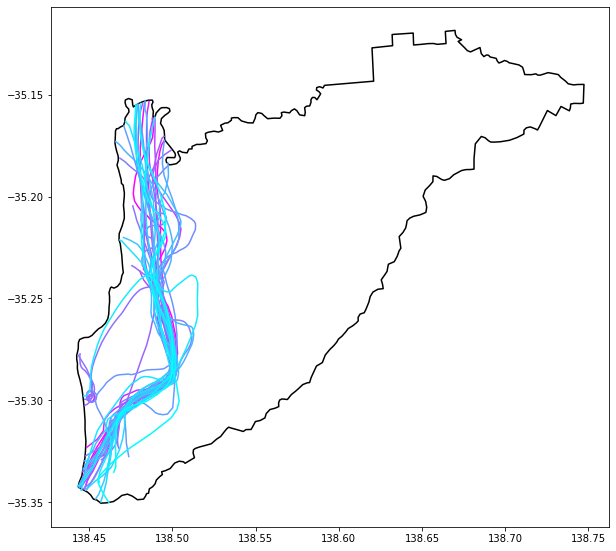

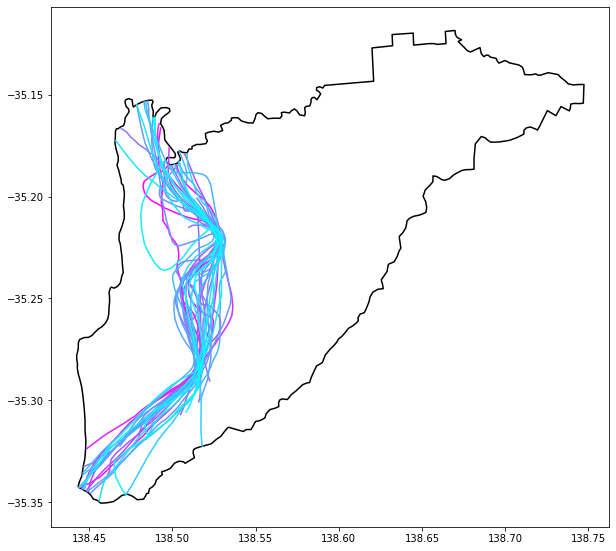

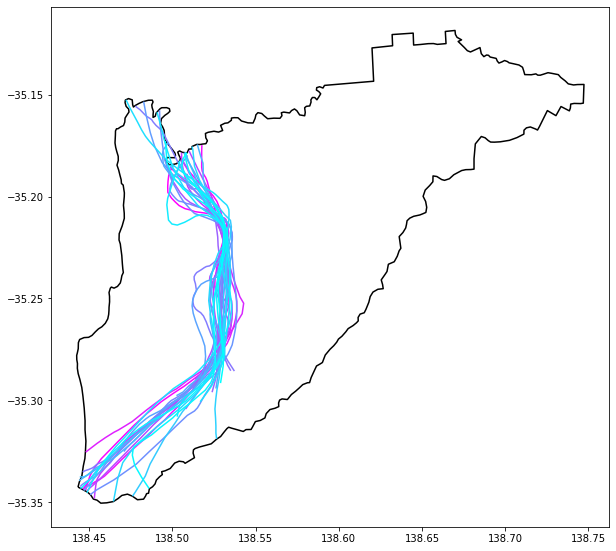

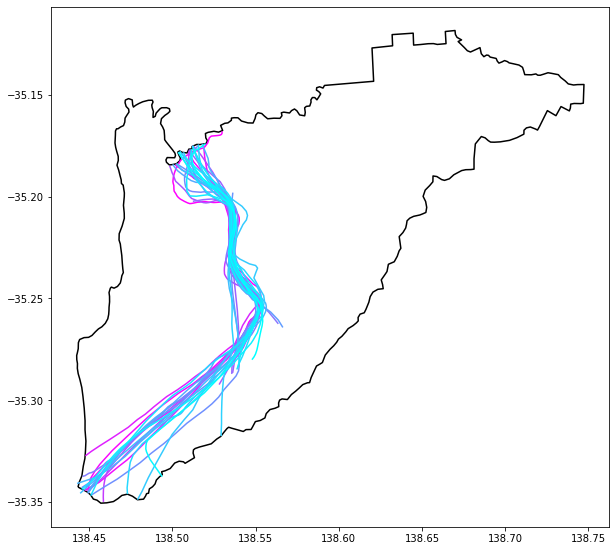

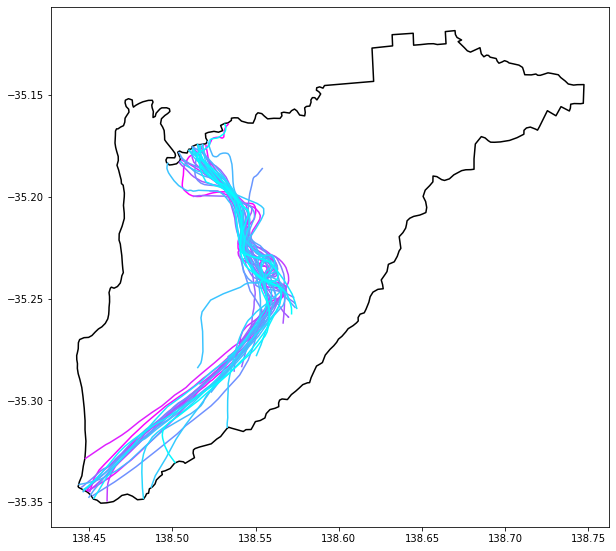

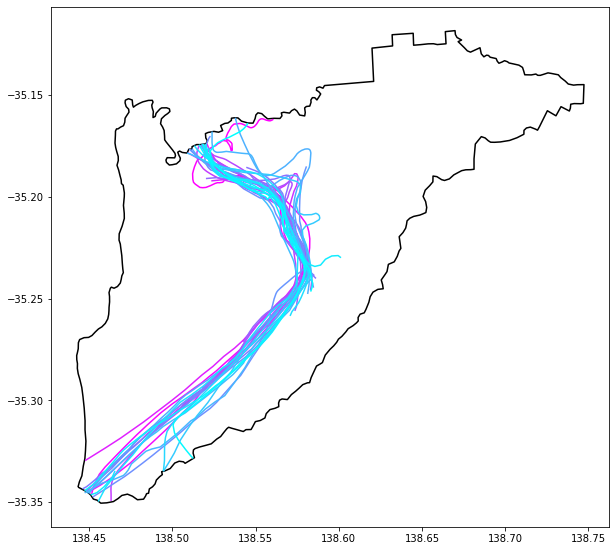

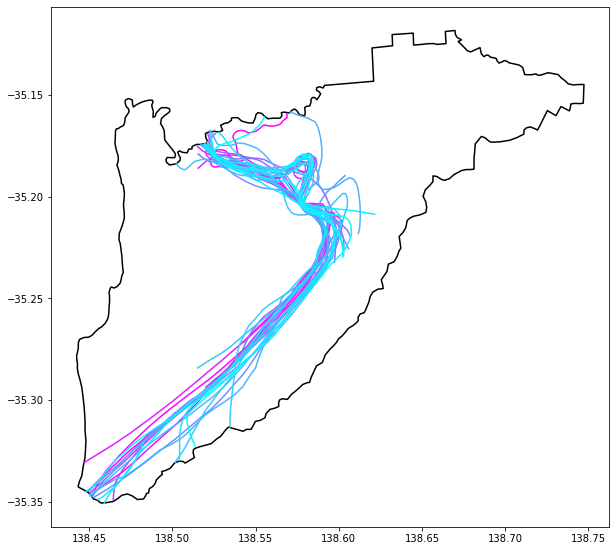

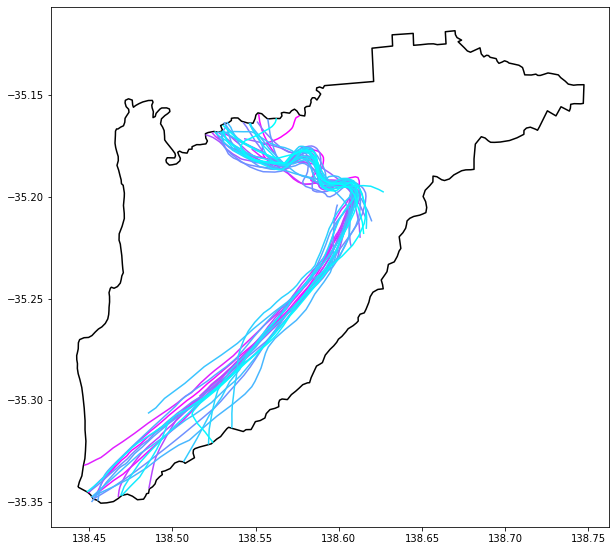

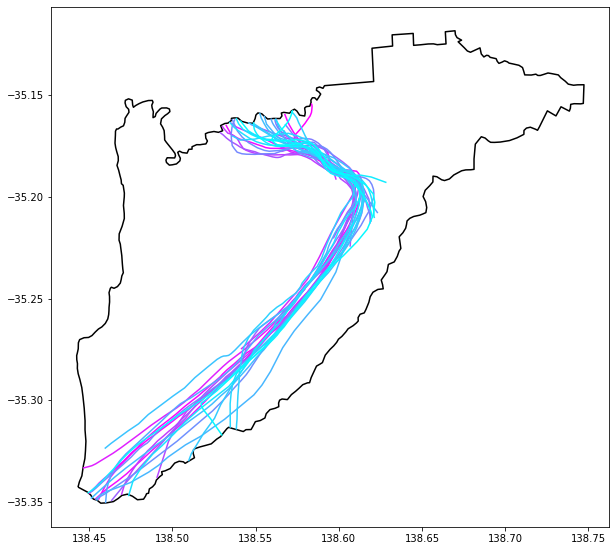

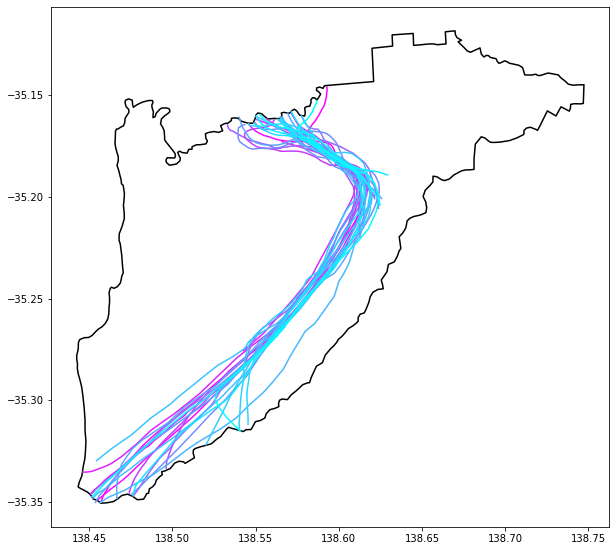

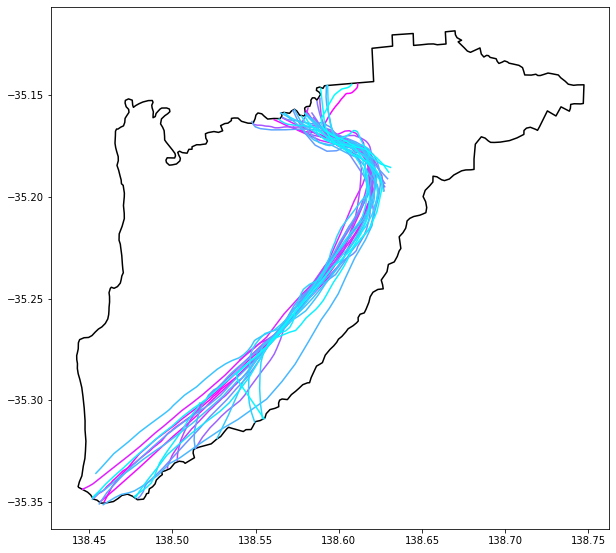

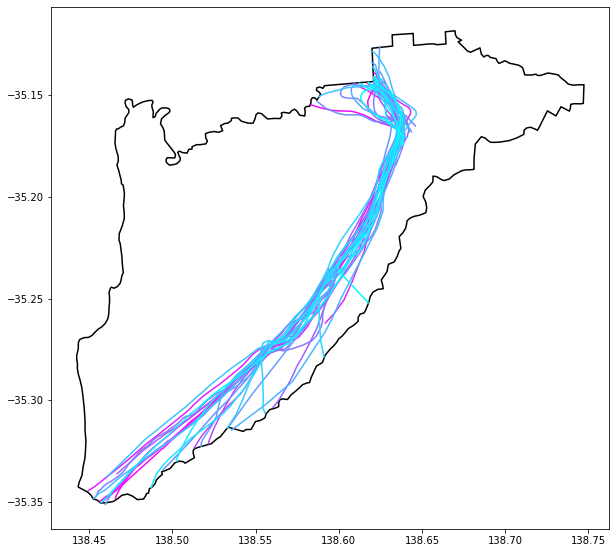

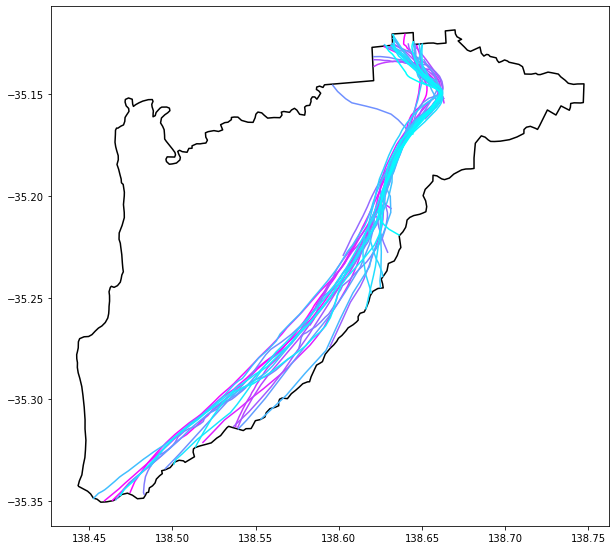

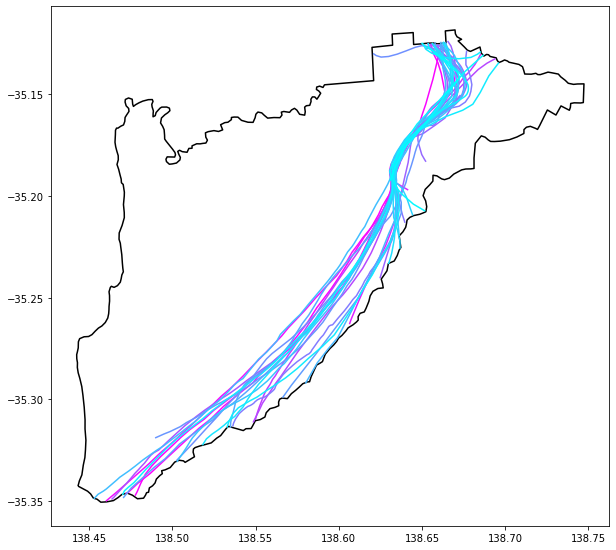

In [124]:
vl=8

survey_levels_1 = survey_levels[1:-1]

for vl in range(len(survey_levels_1)):

    plt.figure(figsize=(10,10))

    ax1=plt.subplot(111)
    study_area_shp.exterior.plot(ax=ax1, color="k", label="Study area")

    colour = cm.cool_r(np.linspace(0, 1, 40))
    contour_v = survey_levels_1[vl]


    for i in range(len(contour_shps_list)):
        #print(contour_shp_name_list[i])
        #print("i:%i"%i)
        c = colour[i]
        contour_shps_list[i][contour_shps_list[i]["Contour_m"]==contour_v].plot(ax=ax1, color=c, label="Contours")

    nm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\Individual_contour_comparison',
                     "contour_value_%i"%contour_v)

    plt.savefig(nm, dpi=300)

## Plot the same thing but as an single figure

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

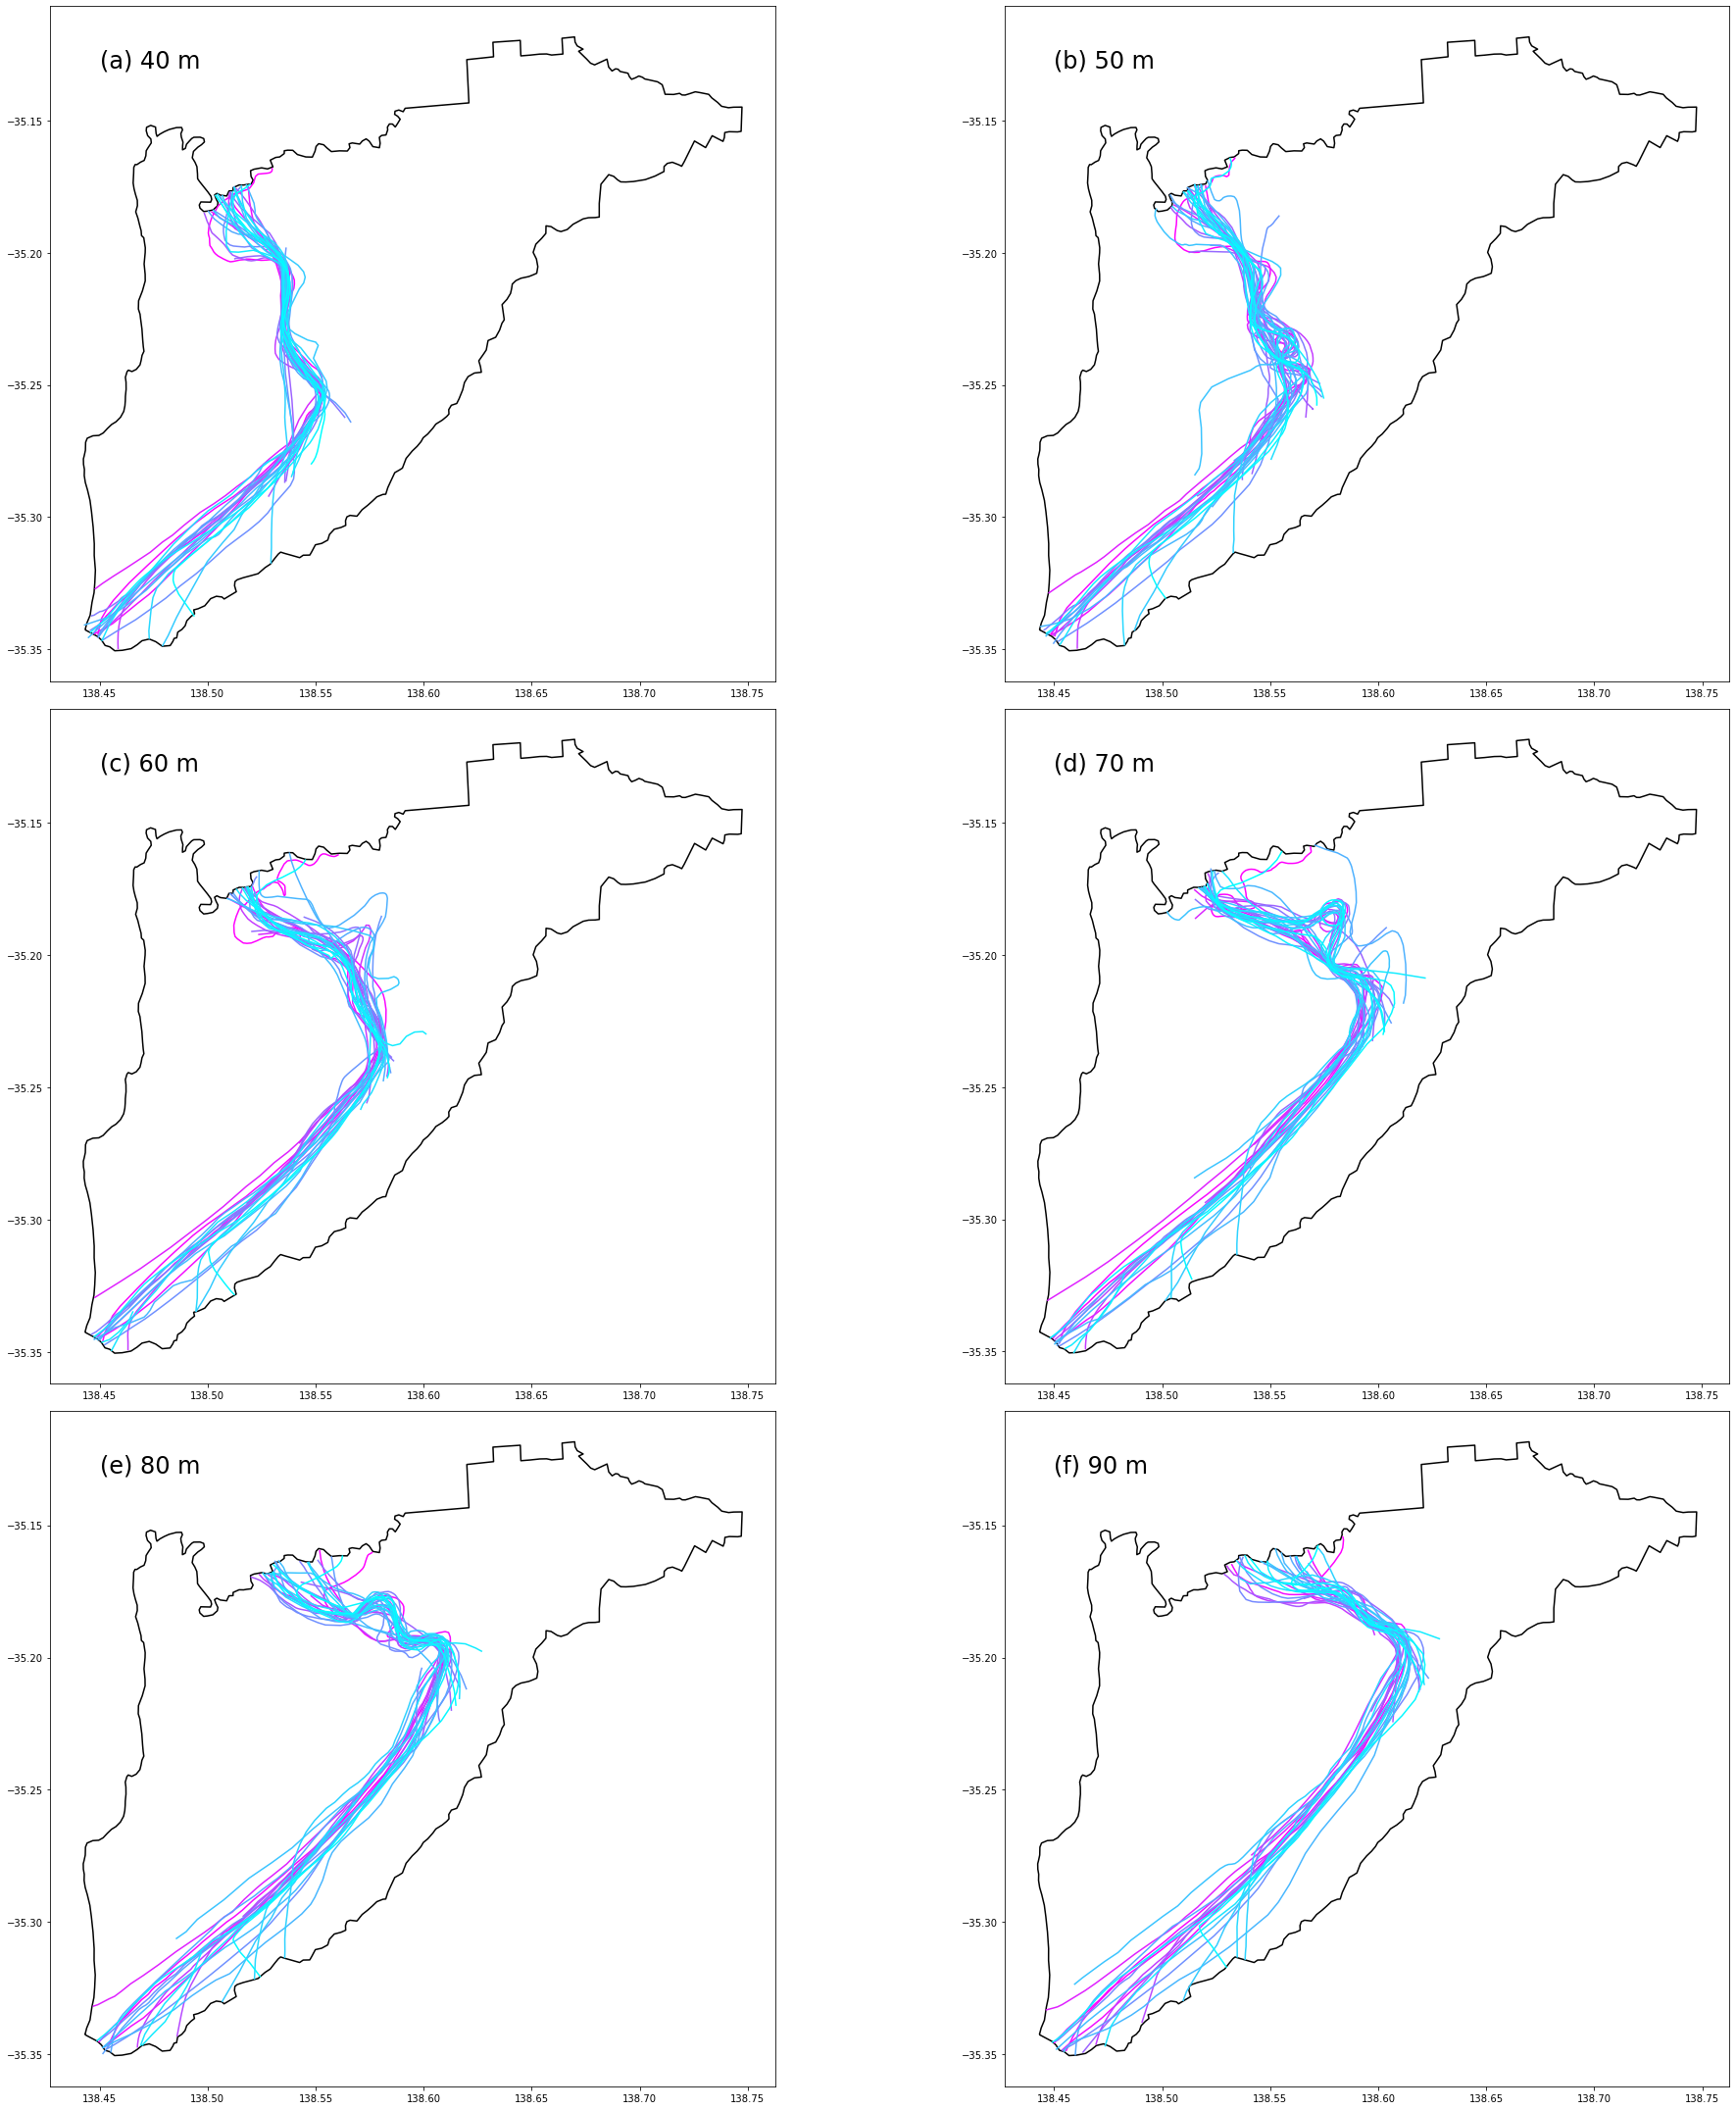

In [131]:
vl=8
survey_levels_1 = [40, 50, 60, 70, 80, 90]

captions = ["(a) 40 m", "(b) 50 m", "(c) 60 m", "(d) 70 m", "(e) 80 m", "(f) 90 m"]

fig = plt.figure(figsize=(30,30))

for vl in range(len(survey_levels_1)):

    ax1=fig.add_subplot(3,2,(vl+1))
    study_area_shp.exterior.plot(ax=ax1, color="k", label="Study area")

    colour = cm.cool_r(np.linspace(0, 1, 40))
    contour_v = survey_levels_1[vl]

    for i in range(len(contour_shps_list)):
        #print(contour_shp_name_list[i])
        #print("i:%i"%i)
        c = colour[i]
        contour_shps_list[i][contour_shps_list[i]["Contour_m"]==contour_v].plot(ax=ax1, color=c, label="Contours")
        
    plt.text(138.45,-35.13,captions[vl], fontsize=24)

plt.tight_layout()
nm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\Individual_contour_comparison',
                     "some_contours")

plt.savefig(nm, dpi=300)

# Plot regions of the figure to show variation

This figure is not very effective - the indiviual contours look better

(-35.23, -35.13)

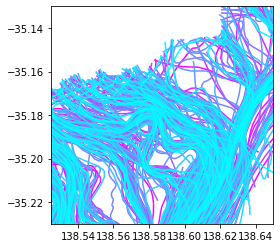

In [139]:
plt.figure()
ax1=plt.subplot(111)

colour = cm.cool_r(np.linspace(0, 1, 40))


for i in range(len(contour_shps_list)):
        #print(contour_shp_name_list[i])
        #print("i:%i"%i)
        c = colour[i]
        contour_shps_list[i].plot(ax=ax1, color=c, label="Contours")
        
plt.xlim([138.525, 138.65])
plt.ylim([-35.23, -35.13])
#ax1.invert_yaxis()